# Analysis of Indian Restaurants in New York

## 1. Introduction:

New York City's demographics show that it is a large and ethnically diverse metropolis. It is the largest city in the United States with a long history of international immigration. New York City was home to nearly 8.5 million people in 2014, accounting for over 40% of the population of New York State.

Indians in the New York City metropolitan region constitute one of the largest and fastest growing ethnicities in the New York City metropolitan area. The New York City region is home to the largest Indian American population among metropolitan areas by a significant margin.

Due to large number of Indians in the city, Indian cuisine is very popular in and around New York. The growth in the New York City metropolitan region's Indian populace has been accompanied by growth in the number of Indian restaurants, located both within and outside of traditional Indian enclaves, such that within New York City proper alone, there are hundreds of Indian restaurants.

## 2. Problem Definition:

Looking at all these Indian restaurants we can perform data analysis on them in the following way:-

1. Visualize all the parts of New York City that have Indian restaurants.
2. Top ranked Indian restaurants in New York City.
3. Which areas have best Indian restaurants?
4. Which areas lack good Indian restaurants?
5. Which all areas have potential Indian restaurant market?
6. Which areas are suitable for living if one prefers Indian cuisine?

## 3. Data:

1. New York City data that contains list Boroughs, Neighbourhoods along with their latitude and longitude from        https://cocl.us/new_york_dataset .
2. Indian restaurants in each neighbourhood of New York City using Foursquare API.
3. GeoSpace data that will help visualize choropleth map.

## 4. Methodology:

Following steps were followed:-

1. First we import New York City Data that contains list Boroughs, Neighbourhoods along with their latitude and longitude from    https://cocl.us/new_york_dataset.
2. Using the latitude and longitude, we find venues for each Neighborhood via Foursquare API.
3. Then we filter out all the Indian Restaurants.
4. Next we retrieve information - Ratings, Likes, Tips for each Indian Restaurant, again by using Foursquare API.
5. Perform analysis on the data obtained.
6. Visualize the conclusions on the map of New York.

## 5. Code:

### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
#!pip install geocoder
import geocoder
import os
#!pip install folium
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Libraries imported.


### Variables required for Foursquare API

In [2]:
CLIENT_ID = 'T4YEZRF0KPTNT4WZZBWSPFKVV2SQ0INIZUC4CLGFV3QSLIWD' # your Foursquare ID
CLIENT_SECRET = 'SKVJUI1OZSTCTMLJJFMQBBLEKNESTZVF4A3ERVIHDSUS4NCB' # your Foursquare Secret
VERSION = 'YYYYMMDD' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
ACCESS_TOKEN = 'DZZDYAU3QADAGIKT04N5AVLETSZTO2GDSOKS3FXRXS1CE1D0'


print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: T4YEZRF0KPTNT4WZZBWSPFKVV2SQ0INIZUC4CLGFV3QSLIWD
CLIENT_SECRET:SKVJUI1OZSTCTMLJJFMQBBLEKNESTZVF4A3ERVIHDSUS4NCB


### Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [3]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

#### We define a function to interact with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.

In [4]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=10000
    CLIENT_ID = ['CLIENT_ID'] # your Foursquare ID
    CLIENT_SECRET = ['CLIENT_SECRET'] # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    ACCESS_TOKEN = 'DZZDYAU3QADAGIKT04N5AVLETSZTO2GDSOKS3FXRXS1CE1D0'
    
    #url to fetch data from foursquare api
   # url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&oauth_token={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, ACCESS_TOKEN, VERSION, lat, lng, radius, LIMIT)     
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

#### Now we will define a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.

In [5]:
def get_venue_details(venue_id):
        
    CLIENT_ID = ['CLIENT_ID'] # your Foursquare ID
    CLIENT_SECRET = ['CLIENT_SECRET'] # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    ACCESS_TOKEN = 'DZZDYAU3QADAGIKT04N5AVLETSZTO2GDSOKS3FXRXS1CE1D0'
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&oauth_token={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET,
            ACCESS_TOKEN,
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

#### Now we define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [6]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [7]:
new_york_data=get_new_york_data()

In [8]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [24]:
new_york_data.shape

(306, 4)

### The above result shows that there are 306 different Neighborhoods in New York.

#### Now let's create a BAR PLOT to show different Neighborhoods in New York.

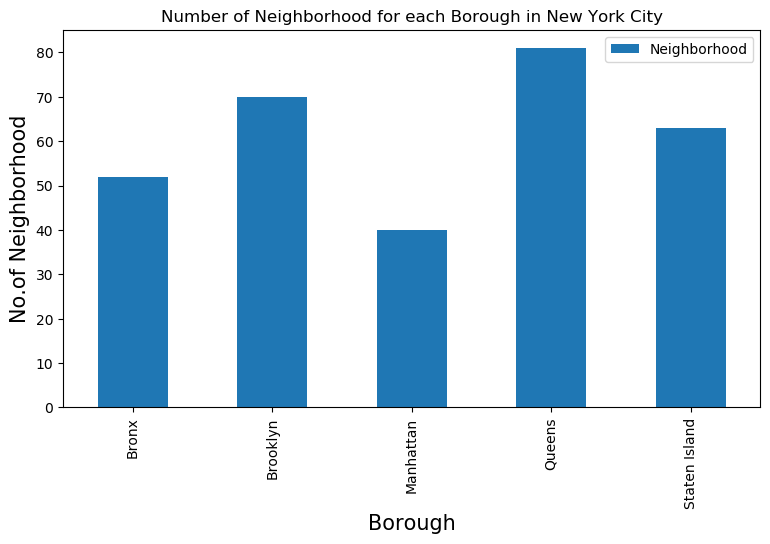

In [9]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

### From the above Bar Plot, we can see that Queens has highest number of neighborhoods.

#### Retrieving venues in a neighborhood, filtering only those venues that are 'Indian Restaurants' and populating them in a dataframe

In [10]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Indian Resturants in Wakefield, Bronx:0
( 2 / 306 ) Indian Resturants in Co-op City, Bronx:0
( 3 / 306 ) Indian Resturants in Eastchester, Bronx:0
( 4 / 306 ) Indian Resturants in Fieldston, Bronx:0
( 5 / 306 ) Indian Resturants in Riverdale, Bronx:1
( 6 / 306 ) Indian Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Indian Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Indian Resturants in Woodlawn, Bronx:1
( 9 / 306 ) Indian Resturants in Norwood, Bronx:0
( 10 / 306 ) Indian Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Indian Resturants in Baychester, Bronx:0
( 12 / 306 ) Indian Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Indian Resturants in City Island, Bronx:0
( 14 / 306 ) Indian Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Indian Resturants in University Heights, Bronx:0
( 16 / 306 ) Indian Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Indian Resturants in Fordham, Bronx:0
( 18 / 306 ) Indian Resturants in East Tremont, Bronx:0
( 19 / 306 ) Ind

( 143 / 306 ) Indian Resturants in Maspeth, Queens:0
( 144 / 306 ) Indian Resturants in Ridgewood, Queens:1
( 145 / 306 ) Indian Resturants in Glendale, Queens:0
( 146 / 306 ) Indian Resturants in Rego Park, Queens:1
( 147 / 306 ) Indian Resturants in Woodhaven, Queens:0
( 148 / 306 ) Indian Resturants in Ozone Park, Queens:0
( 149 / 306 ) Indian Resturants in South Ozone Park, Queens:1
( 150 / 306 ) Indian Resturants in College Point, Queens:0
( 151 / 306 ) Indian Resturants in Whitestone, Queens:0
( 152 / 306 ) Indian Resturants in Bayside, Queens:3
( 153 / 306 ) Indian Resturants in Auburndale, Queens:0
( 154 / 306 ) Indian Resturants in Little Neck, Queens:0
( 155 / 306 ) Indian Resturants in Douglaston, Queens:0
( 156 / 306 ) Indian Resturants in Glen Oaks, Queens:4
( 157 / 306 ) Indian Resturants in Bellerose, Queens:2
( 158 / 306 ) Indian Resturants in Kew Gardens Hills, Queens:1
( 159 / 306 ) Indian Resturants in Fresh Meadows, Queens:0
( 160 / 306 ) Indian Resturants in Briarw

( 280 / 306 ) Indian Resturants in Fulton Ferry, Brooklyn:0
( 281 / 306 ) Indian Resturants in Vinegar Hill, Brooklyn:0
( 282 / 306 ) Indian Resturants in Weeksville, Brooklyn:0
( 283 / 306 ) Indian Resturants in Broadway Junction, Brooklyn:1
( 284 / 306 ) Indian Resturants in Dumbo, Brooklyn:0
( 285 / 306 ) Indian Resturants in Manor Heights, Staten Island:0
( 286 / 306 ) Indian Resturants in Willowbrook, Staten Island:0
( 287 / 306 ) Indian Resturants in Sandy Ground, Staten Island:0
( 288 / 306 ) Indian Resturants in Egbertville, Staten Island:0
( 289 / 306 ) Indian Resturants in Roxbury, Queens:0
( 290 / 306 ) Indian Resturants in Homecrest, Brooklyn:0
( 291 / 306 ) Indian Resturants in Middle Village, Queens:0
( 292 / 306 ) Indian Resturants in Prince's Bay, Staten Island:0
( 293 / 306 ) Indian Resturants in Lighthouse Hill, Staten Island:0
( 294 / 306 ) Indian Resturants in Richmond Valley, Staten Island:0
( 295 / 306 ) Indian Resturants in Malba, Queens:0
( 296 / 306 ) Indian Re

In [11]:
indian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Riverdale,4c04544df423a593ac83d116,Cumin Indian Cuisine
1,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
2,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
3,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine
4,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird


In [12]:
indian_rest_ny.shape

(147, 4)

### From the above result, we see that there are 151 Indian Resturants across New York City.

#### Now let create a BAR PLOT to show Number of Indian Resturants for each Borough in New York City.

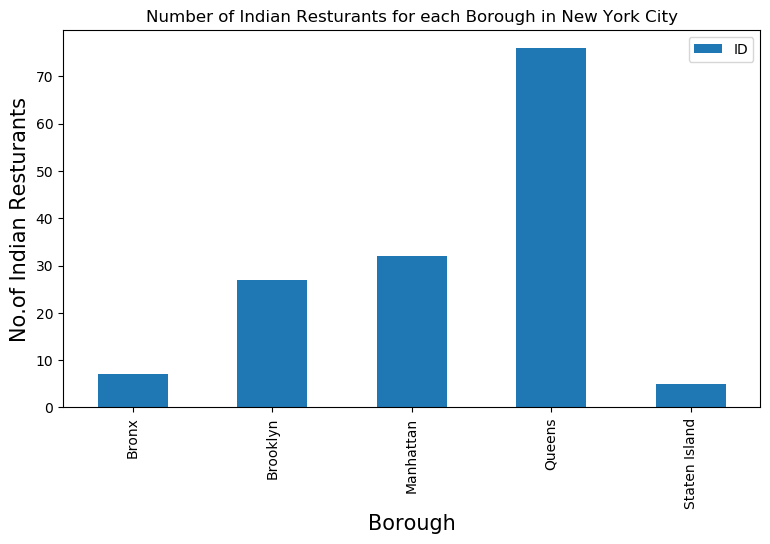

In [13]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()


### From the above Bar Plot, we can see that Queens has highest number of Indian resturants.

#### Now let create a BAR PLOT to show Number of Indian Resturants for each Neighborhood in New York City.

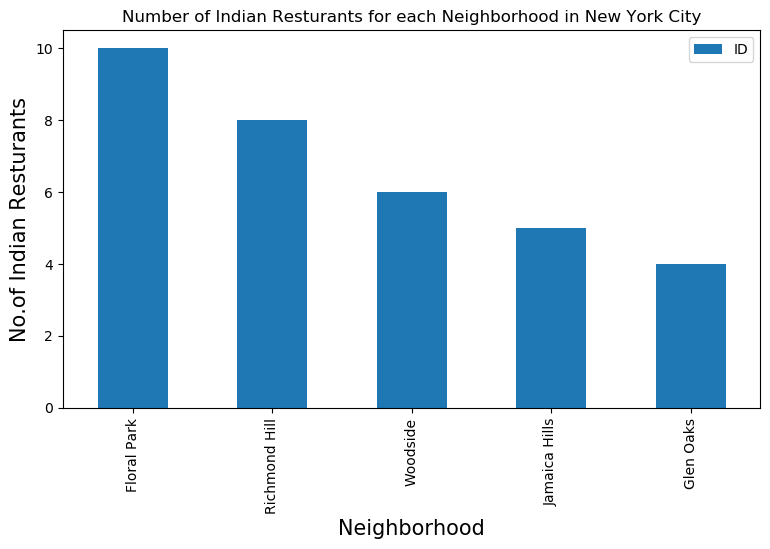

In [14]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

#### From the above Bar Plot, we can see that Floral Park has highest number of Indian resturants.

In [15]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park']

,Borough,Neighborhood,ID,Name
104,Queens,Floral Park,527ffc0811d2d329d5e49abd,Jackson Diner
105,Queens,Floral Park,4e4e3e22bd4101d0d7a5c2d1,Kerala Kitchen
106,Queens,Floral Park,4b647b56f964a520c4b62ae3,Usha Foods & Usha Sweets
107,Queens,Floral Park,4b787c49f964a5209cd12ee3,Santoor Indian Restaurant
108,Queens,Floral Park,4c0c01e0bbc676b00d6b4cd5,Mumbai Xpress
109,Queens,Floral Park,4c76ff35a5676dcb72671721,Flavor Of India
110,Queens,Floral Park,4df0f39dd4c04d0392c853ea,Sagar Chinese
111,Queens,Floral Park,4f4982b0e4b04a413003aaa7,Flavor of India
112,Queens,Floral Park,4cc642ed306e224b5bf2a76c,Shahi Darbar
113,Queens,Floral Park,5d06c43cc03635002cc463f2,Honest


#### We can see that, Floral Park in Queens has the highest number of Indian Resturants with a total count of 10.

#### Now we will get the ranking of each resturant for further analysis.

In [16]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID                  Name  Likes  Rating  Tips
0  4c04544df423a593ac83d116  Cumin Indian Cuisine     13     5.8     9
( 1 / 147 ) processed
                         ID        Name  Likes  Rating  Tips
0  4c0448d9310fc9b6bf1dc761  Curry Spot      5     7.9    10
( 2 / 147 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.2     2
( 3 / 147 ) processed
                         ID                  Name  Likes  Rating  Tips
0  4c04544df423a593ac83d116  Cumin Indian Cuisine     13     5.8     9
( 4 / 147 ) processed
                         ID         Name  Likes  Rating  Tips
0  551b7f75498e86c00a0ed2e1  Hungry Bird      8     7.2     3
( 5 / 147 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.2     2
( 6 / 147 ) processed
                         I

                         ID       Name  Likes  Rating  Tips
0  5d8d9c5e0a2ffc0008f28855  The Gully      7     8.5     4
( 54 / 147 ) processed
                         ID                 Name  Likes  Rating  Tips
0  4aa56c81f964a5204e4820e3  Seva Indian Cuisine    241     9.1   133
( 55 / 147 ) processed
                         ID                Name  Likes  Rating  Tips
0  59b9d25d0d173f3bdf654d77  Tikka Indian Grill      6     8.2     4
( 56 / 147 ) processed
                         ID                      Name  Likes  Rating  Tips
0  4b998d3ff964a520fc8235e3  Maharaja Sweets & Snacks     54     8.4    25
( 57 / 147 ) processed
                         ID            Name  Likes  Rating  Tips
0  4afdcf29f964a520162b22e3  Rajbhog Sweets     36     8.1    25
( 58 / 147 ) processed
                         ID  Name  Likes  Rating  Tips
0  4b189424f964a52043d423e3  Dera     48     7.7    19
( 59 / 147 ) processed
                         ID      Name  Likes  Rating  Tips
0  4c7060e73444

                         ID                      Name  Likes  Rating  Tips
0  4b647b56f964a520c4b62ae3  Usha Foods & Usha Sweets     34     7.7    10
( 107 / 147 ) processed
                         ID                       Name  Likes  Rating  Tips
0  4b787c49f964a5209cd12ee3  Santoor Indian Restaurant     37     7.4    18
( 108 / 147 ) processed
                         ID           Name  Likes  Rating  Tips
0  4c0c01e0bbc676b00d6b4cd5  Mumbai Xpress     16     6.7    18
( 109 / 147 ) processed
                         ID             Name  Likes  Rating  Tips
0  4c76ff35a5676dcb72671721  Flavor Of India      6     5.8     6
( 110 / 147 ) processed
                         ID           Name  Likes  Rating  Tips
0  4df0f39dd4c04d0392c853ea  Sagar Chinese      7     6.2     6
( 111 / 147 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4f4982b0e4b04a413003aaa7
( 112 / 147 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Ratin

In [17]:
indian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Riverdale,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,5.8,9
1,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.9,10
2,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.2,2
3,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,5.8,9
4,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,7.2,3


In [18]:
indian_rest_stats_ny.shape

(147, 7)

In [19]:
indian_rest_ny.shape

(147, 4)

#### Now that we got data for all resturants Now lets save this data to a csv sheet.

In [20]:
indian_rest_stats_ny.to_csv('indian_rest_stats_ny.csv', index=False)

In [21]:
indian_rest_stats_ny_csv=pd.read_csv('indian_rest_stats_ny.csv')

In [22]:
indian_rest_stats_ny_csv.shape

(147, 7)

In [23]:
indian_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Riverdale,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,5.8,9
1,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.9,10
2,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.2,2
3,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,5.8,9
4,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,7.2,3


In [24]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 7 columns):
Borough         147 non-null object
Neighborhood    147 non-null object
ID              147 non-null object
Name            147 non-null object
Likes           147 non-null object
Rating          147 non-null float64
Tips            147 non-null object
dtypes: float64(1), object(6)
memory usage: 8.2+ KB


#### The Data type of 'Likes' and 'Tips' are of type 'String'. we will convert them into type 'Float' for further analysis.

In [25]:
indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')
indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')

In [26]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 7 columns):
Borough         147 non-null object
Neighborhood    147 non-null object
ID              147 non-null object
Name            147 non-null object
Likes           147 non-null float64
Rating          147 non-null float64
Tips            147 non-null float64
dtypes: float64(3), object(4)
memory usage: 8.2+ KB


#### Now we will find the Indian restuarants with Maximum Likes, Maximum Ratings and Maximum Tips.

In [27]:
# Resturant with maximum Likes
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                600
Rating                                 9
Tips                                 150
Name: 43, dtype: object

In [28]:
# Resturant with maximum Rating
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                           Queens
Neighborhood                     Astoria
ID              4aa56c81f964a5204e4820e3
Name                 Seva Indian Cuisine
Likes                                241
Rating                               9.1
Tips                                 133
Name: 54, dtype: object

In [29]:
# Resturant with maximum Tips
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                    Gramercy
ID              4a70a75bf964a52016d81fe3
Name                 Bhatti Indian Grill
Likes                                424
Rating                               8.8
Tips                                 162
Name: 51, dtype: object

#### Next lets visualize neighborhood with maximum average rating of resturants.

In [30]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [31]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
4,Blissville,9.10
65,Sunnyside,9.10
69,Tribeca,9.00
11,Civic Center,9.00
75,West Village,8.95
49,Prospect Heights,8.90
10,Chelsea,8.80
26,Gramercy,8.75
70,Tudor City,8.70
0,Astoria,8.60


#### Similarly we will find the average rating of Indian Resturants for each Borough.

In [32]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [33]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.312500
1,Brooklyn,7.437037
0,Bronx,6.614286
4,Staten Island,6.360000
3,Queens,5.990789


#### Lets Visualize it.

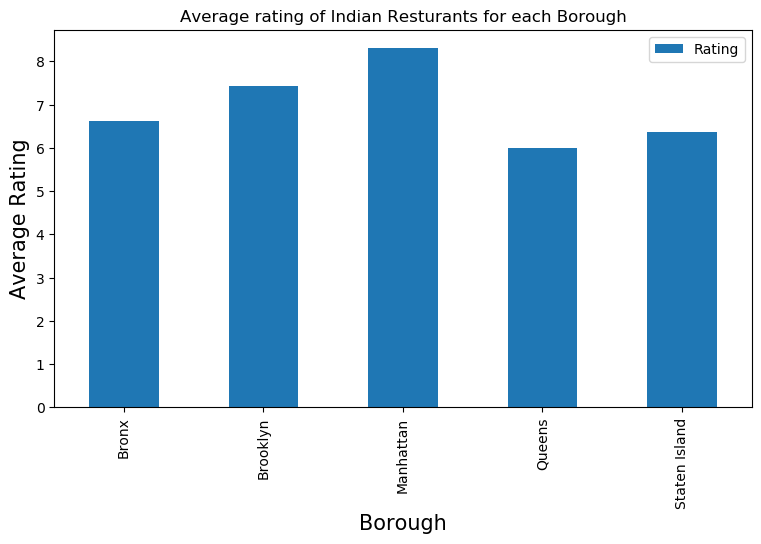

In [34]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

#### We will consider all the neighborhoods with average rating greater or equal 9.0 to visualize on map.

In [35]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]

In [36]:
ny_neighborhood_stats

,Neighborhood,Average Rating
4,Blissville,9.1
11,Civic Center,9.0
65,Sunnyside,9.1
69,Tribeca,9.0


#### We will join this dataset to original new york data to get lonitude and latitude.

In [37]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [38]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [39]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Blissville,40.737251,-73.932442,9.1
1,Manhattan,Civic Center,40.715229,-74.005415,9.0
2,Queens,Sunnyside,40.740176,-73.926916,9.1
3,Staten Island,Sunnyside,40.612760,-74.097126,9.1
4,Manhattan,Tribeca,40.721522,-74.010683,9.0


#### Finally, Let's show this data on a map.

In [40]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [41]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the neighborhood and add each to the feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [42]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [46]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

## 6. Conclusion

### Now, with all the analysis done, we found answers to all the questions below:-

1. Which areas have best Indian restaurants? - Blissville (Queens), Civic Center(Manhattan), Sunnyside (Queens) are some of the   best Neighborhoods with Indian Restaurants
2. Top ranked Indian restaurants in New York City are Seva Indian Cuisine (Rating-9.1), Tamarind TriBeca (Likes-600), Bhatti Indian Grill (Tips-162).
3. Which areas are suitable for living if one prefers Indian cuisine? - Manhattan is the suitable place to stay if one prefers    Indian cuisine since the average rating of Restaurants in Manhattan is the highest (8.31).
4. Which areas lack good Indian restaurants - Staten Island.
5. Which all areas have potential Indian Restaurant market - Manhattan & Brooklyn have potential Indian Restaurant market.